<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Multi-layer Perceptron (MLP)

###Install dependencies

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 KB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.4 MB/s eta 0:00:00


###Load Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from keras.callbacks import EarlyStopping
from time import time
import pickle

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

In [3]:
import random as python_random
def reset_seeds():
   np.random.seed(123) 
   python_random.seed(123)
   tf.random.set_seed(1234)

reset_seeds()

###Define Functions to Facilitate Metrics Evaluation

In [4]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [5]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/FS_2.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
0,12/1/10,323,455,3102.61,423.45,844.0,468.0,578.0
1,1/1/11,345,546,3100.45,415.85,799.0,485.0,557.0
2,2/1/11,362,595,3199.41,410.77,718.0,466.0,552.0
3,3/1/11,376,636,3281.67,414.82,614.0,442.0,574.0
4,4/1/11,383,738,3261.65,451.04,619.0,429.0,595.0


In [6]:
df['date']=pd.to_datetime(df['date'])
#del df['date']

In [7]:
df.set_index('date', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124 entries, 2010-12-01 to 2021-03-01
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   cpo_pri  124 non-null    int64  
 1   cno_pri  124 non-null    int64  
 2   oli_pri  124 non-null    float64
 3   rps_pri  124 non-null    float64
 4   pno_pri  124 non-null    float64
 5   sbo_pri  124 non-null    float64
 6   sfo_pri  124 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 7.8 KB


In [8]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


<Figure size 1800x720 with 0 Axes>

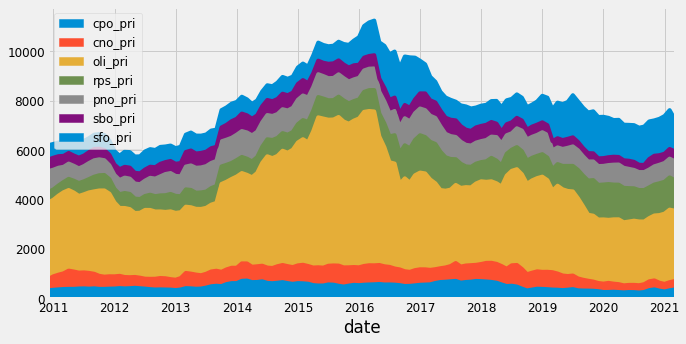

In [9]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Multi-layer Perceptron Forecasting Technique (MLP)**

###**Split Data into Train Test Segments**

In [10]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [11]:
split_date = '2019-02'
df_training = df.loc[df.index <= split_date]
df_test = df.loc[df.index > split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

99 days of training data 
 25 days of testing data 


In [12]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [13]:
print(train.shape)
train.head()

(99, 7)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0


###Rescaling Training Data

In [14]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621


In [15]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [16]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri
date,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462


In [17]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [27]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 7) (96,)


In [28]:
X_train_mlp = X_train[:, :, 0]
X_test_mlp = X_test[:, :, 0]
mlp_model = tf.keras.Sequential()
mlp_model.add(tf.keras.layers.Dense(85, input_dim=X_train.shape[1], activation='relu'))
mlp_model.add(tf.keras.layers.Dense(64, activation = 'relu'))
mlp_model.add(tf.keras.layers.Dense(1))

In [29]:
mlp_model.compile(loss='mse',metrics=['mse'], optimizer='adam')
mlp_model

# model training
mlp_history = mlp_model.fit(
    X_train_mlp, y_train, 
    epochs=100, 
    batch_size=32, 
    validation_split=0.1,
    shuffle=False
)

# model evaluation
mlp_model.evaluate(X_test_mlp, y_test)

Epoch 1/100
3/3 [==============================] - 2s 196ms/step - loss: 0.3618 - mse: 0.3618 - val_loss: 0.0778 - val_mse: 0.0778
Epoch 2/100
3/3 [==============================] - 0s 31ms/step - loss: 0.2118 - mse: 0.2118 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 3/100
3/3 [==============================] - 0s 31ms/step - loss: 0.1065 - mse: 0.1065 - val_loss: 0.0146 - val_mse: 0.0146
Epoch 4/100
3/3 [==============================] - 0s 32ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 5/100
3/3 [==============================] - 0s 34ms/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 6/100
3/3 [==============================] - 0s 30ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0794 - val_mse: 0.0794
Epoch 7/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0981 - val_mse: 0.0981
Epoch 8/100
3/3 [==============================] - 0s 23ms/step - loss: 0.0299 - mse: 0.0

[0.020143277943134308, 0.020143277943134308]

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


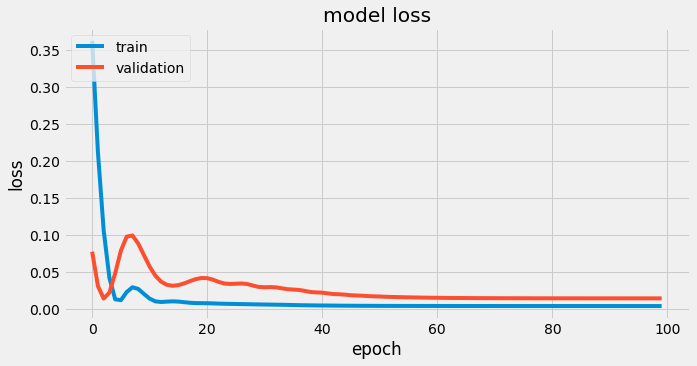

In [30]:
print(mlp_history.history.keys())
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [31]:
mse_mlp = mlp_model.evaluate(X_test_mlp, y_test)

1/1 [==============================] - 0s 25ms/step - loss: 0.0201 - mse: 0.0201


Baseline MSE = 0.0201

In [32]:
mlp_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 85)                340       
                                                                 
 dense_7 (Dense)             (None, 64)                5504      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,909
Trainable params: 5,909
Non-trainable params: 0
_________________________________________________________________


###Predict the Test without Hyperparameter Tuning

In [33]:
y_pred = mlp_model.predict(X_test_mlp)
y_pred

1/1 [==============================] - 0s 79ms/step


array([[ 0.05506507],
       [ 0.10693558],
       [ 0.15263079],
       [ 0.02604022],
       [ 0.02698061],
       [ 0.02282983],
       [ 0.01438005],
       [ 0.0008309 ],
       [-0.01491748],
       [ 0.04113096],
       [ 0.05446173],
       [ 0.03484177],
       [ 0.03193814],
       [ 0.06638189],
       [ 0.04638808],
       [ 0.03307782],
       [ 0.074045  ],
       [ 0.11569221],
       [ 0.11050653],
       [-0.00454815],
       [-0.02794061],
       [ 0.07646514]], dtype=float32)

In [34]:
y_pred.reshape(1,-1)

array([[ 0.05506507,  0.10693558,  0.15263079,  0.02604022,  0.02698061,
         0.02282983,  0.01438005,  0.0008309 , -0.01491748,  0.04113096,
         0.05446173,  0.03484177,  0.03193814,  0.06638189,  0.04638808,
         0.03307782,  0.074045  ,  0.11569221,  0.11050653, -0.00454815,
        -0.02794061,  0.07646514]], dtype=float32)

###Invert Transformed Data

In [35]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[341.02603 361.77423 380.05234 329.41608 329.79224 328.13193 324.752
  319.33237 313.03302 335.4524  340.7847  332.9367  331.77527 345.55276
  337.55524 332.23114 348.618   365.2769  363.2026  317.18073 307.82376
  349.58606]]


###Plot History, Actual and Predicted Value

In [36]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [37]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [38]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([341.02603, 361.77423, 380.05234, 329.41608, 329.79224, 328.13193,
       324.752  , 319.33237, 313.03302, 335.4524 , 340.7847 , 332.9367 ,
       331.77527, 345.55276, 337.55524, 332.23114, 348.618  , 365.2769 ,
       363.2026 , 317.18073, 307.82376, 349.58606], dtype=float32)

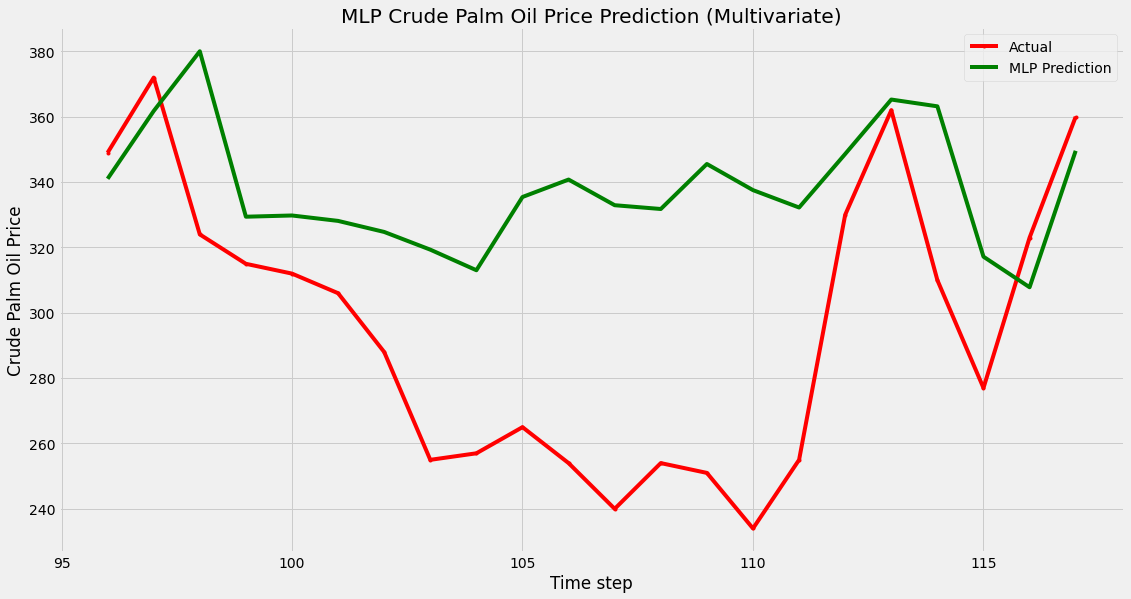

In [39]:
plt.figure(figsize=(17,9))
#plt.grid()
#plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='red', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='green', label="MLP Prediction")
plt.title("MLP Crude Palm Oil Price Prediction (Multivariate)")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
ax.grid()
plt.savefig('graph_MLP.png')

In [40]:
y_pred_inv

array([341.02603, 361.77423, 380.05234, 329.41608, 329.79224, 328.13193,
       324.752  , 319.33237, 313.03302, 335.4524 , 340.7847 , 332.9367 ,
       331.77527, 345.55276, 337.55524, 332.23114, 348.618  , 365.2769 ,
       363.2026 , 317.18073, 307.82376, 349.58606], dtype=float32)

In [43]:
MLP = y_pred_inv 
dfmlp=pd.DataFrame(MLP, columns=['MLP_Prediction']) 
print (dfmlp)

    MLP_Prediction
0       341.026031
1       361.774231
2       380.052338
3       329.416077
4       329.792236
5       328.131927
6       324.752014
7       319.332367
8       313.033020
9       335.452393
10      340.784698
11      332.936707
12      331.775269
13      345.552765
14      337.555237
15      332.231140
16      348.618011
17      365.276886
18      363.202606
19      317.180725
20      307.823761
21      349.586060


In [44]:
#Save MLP prediction to csv file
dfmlp.to_csv("MLP_Prediction.csv")

###Evaluate MLP Model Accuracy

In [45]:
MAE_MLP = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the MLP Model is:', MAE_MLP)

MDA_MLP = mda(y_test_inv, y_pred_inv)
print('MDA value of the MLP Model is:', MDA_MLP)

MAPE_MLP = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the MLP Model is:', MAPE_MLP)

RMSE_MLP = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the MLP Model is:', RMSE_MLP)

MSE_MLP = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the MLP Model is:', MSE_MLP)

MAE value of the MLP Model is: 46.81210604580966
MDA value of the MLP Model is: 0.6190476190476191
MAPE value of the MLP Model is: 17.625104814530786
RMSE value of the MLP Model is: 56.770807561394705
MSE value of the MLP Model is: 3222.92459117291


###Tuning MLP with Keras Tuner

Define A Model-Building Class

In [46]:
class MLPHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
      
        hp_units_1= hp.Int('units_1', min_value=64, max_value= 256, step=8)
        hp_units_2= hp.Int('units_2', min_value=32, max_value= 128, step=8)
        #hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=8)
        #hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2))
        #model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        #model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        #batch_size = hp.Int('batch_size',8,16,24,32,40,48,56,64,72,80,88,96, step=8)
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'AdamW', 'nadam','sgd','adadelta','adagrad'])

        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model
hypermodel = MLPHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [47]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

In [48]:
tuner_rs.search(X_test, y_train, epochs=16, validation_split=0.2, verbose=0)

In [ ]:
X_train_mlp = X_train[:, :, 0]
X_test_mlp = X_test[:, :, 0]
mlp_model = tf.keras.Sequential()
mlp_model.add(tf.keras.layers.Dense(85, input_dim=X_train.shape[1], activation='relu'))
mlp_model.add(tf.keras.layers.Dense(64, activation = 'relu'))
mlp_model.add(tf.keras.layers.Dense(1))

###Build HYPERBAND optimization

In [49]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [50]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!
315.4679501056671  secs


In [51]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 

drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 256,
second layer is 48 

drop out is 0.35000000000000003
batch_size is 48
epoch is 100
optimizer is rmsprop
activation is ELU

momentum is 0.8300000000000001
decay is 0.00010000100000000001

#learning rate is 0.00330588674286921                                        

and the optimal learning rate for the optimizer
is 0.00330588674286921.

[]
1/1 [==============================] - 0s 325ms/step - loss: 0.0119 - mae: 0.0954 - mse: 0.0119
loss:0.011854633688926697 mae: 0.09537635743618011 mse: 0.011854633688926697


In [52]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 256, 'units_2': 48, 'dropout': 0.35000000000000003, 'optimizer': 'rmsprop', 'activation': 'ELU', 'batch_size': 48, 'epoch': 100, 'momentum': 0.8300000000000001, 'decay': 0.00010000100000000001, 'learning_rate': 0.00330588674286921}


###Apply the trained parameters to the MLP

In [63]:
#X_train_mlp = X_train[:, :, 0]
#X_test_mlp = X_test[:, :, 0]
tumlp_model = tf.keras.Sequential()
tumlp_model.add(tf.keras.layers.Dense(256,activation='ELU', input_dim=X_train.shape[1]))
tumlp_model.add(tf.keras.layers.Dense(48, activation = 'ELU'))
tumlp_model.add(tf.keras.layers.Dense(1))

In [60]:
TUMLP_model = tf.keras.Sequential()
TUMLP_model.add(tf.keras.layers.GRU(128, activation='Softmax', input_shape=(X_test.shape[1])))
TUMLP_model.add(tf.keras.layers.Dense(128, activation='Softmax'))
TUMLP_model.add(layers.Dropout(0.45))
#TUGRU_model.add(layers.Dropout(0.35))
#TUGRU_model.add(tf.keras.layers.Dense(16, 'tanh'))
#TUGRU_model.add(layers.Dropout(0.35))

#Output layer of model
TUMLP_model.add(tf.keras.layers.Dense(1, 'linear'))

TypeError: ignored

In [65]:
tumlp_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.RMSprop(learning_rate=0.003305, momentum = 0.83), metrics= ['mae', 'mse'])
history = tumlp_model.fit(X_train_mlp, y_train, epochs=100, batch_size=48,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/100
2/2 [==============================] - 1s 182ms/step - loss: 1.0321 - mae: 0.7949 - mse: 1.0321 - val_loss: 1.3257 - val_mae: 1.0715 - val_mse: 1.3257
Epoch 2/100
2/2 [==============================] - 0s 31ms/step - loss: 0.4804 - mae: 0.6114 - mse: 0.4804 - val_loss: 0.8653 - val_mae: 0.8802 - val_mse: 0.8653
Epoch 3/100
2/2 [==============================] - 0s 37ms/step - loss: 0.4168 - mae: 0.5260 - mse: 0.4168 - val_loss: 0.8900 - val_mae: 0.8974 - val_mse: 0.8900
Epoch 4/100
2/2 [==============================] - 0s 48ms/step - loss: 0.4034 - mae: 0.5927 - mse: 0.4034 - val_loss: 0.1477 - val_mae: 0.3488 - val_mse: 0.1477
Epoch 5/100
2/2 [==============================] - 0s 31ms/step - loss: 0.3221 - mae: 0.5202 - mse: 0.3221 - val_loss: 0.0738 - val_mae: 0.2356 - val_mse: 0.0738
Epoch 6/100
2/2 [==============================] - 0s 31ms/step - loss: 0.0863 - mae: 0.2696 - mse: 0.0863 - val_loss: 0.2934 - val_mae: 0.5180 - val_mse: 0.2934
Epoch 7/100
2/2 [==========

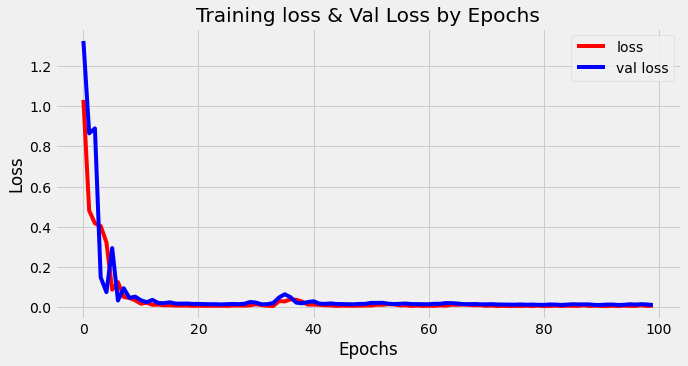

<Figure size 720x360 with 0 Axes>

In [66]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.savefig('OptTLV.png')

In [74]:
y_predTU = tumlp_model.predict(X_test_mlp)
y_predTU

1/1 [==============================] - 1s 526ms/step


array([[ 0.02882143],
       [ 0.09401076],
       [ 0.14195369],
       [-0.02122882],
       [ 0.00624708],
       [-0.011721  ],
       [-0.03052041],
       [-0.0812713 ],
       [-0.1677808 ],
       [-0.13453399],
       [-0.12363759],
       [-0.1650558 ],
       [-0.19432425],
       [-0.14069307],
       [-0.16916952],
       [-0.21376623],
       [-0.13261858],
       [ 0.06823392],
       [ 0.10126897],
       [-0.06206907],
       [-0.10115486],
       [ 0.05339438]], dtype=float32)

In [75]:
y_predTU.reshape(1,-1)

array([[ 0.02882143,  0.09401076,  0.14195369, -0.02122882,  0.00624708,
        -0.011721  , -0.03052041, -0.0812713 , -0.1677808 , -0.13453399,
        -0.12363759, -0.1650558 , -0.19432425, -0.14069307, -0.16916952,
        -0.21376623, -0.13261858,  0.06823392,  0.10126897, -0.06206907,
        -0.10115486,  0.05339438]], dtype=float32)

In [76]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[330.52856 356.6043  375.7815  310.50845 321.4988  314.31158 306.79184
  286.4915  251.88768 265.1864  269.54495 252.97768 241.27031 262.72278
  251.33218 233.49352 265.95258 346.29358 359.5076  294.1724  278.53806
  340.35776]]


In [77]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [78]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [79]:
TU_MLP_Pred = y_pred_inv.flatten()   
TU_MLP_Pred

array([330.52856, 356.6043 , 375.7815 , 310.50845, 321.4988 , 314.31158,
       306.79184, 286.4915 , 251.88768, 265.1864 , 269.54495, 252.97768,
       241.27031, 262.72278, 251.33218, 233.49352, 265.95258, 346.29358,
       359.5076 , 294.1724 , 278.53806, 340.35776], dtype=float32)

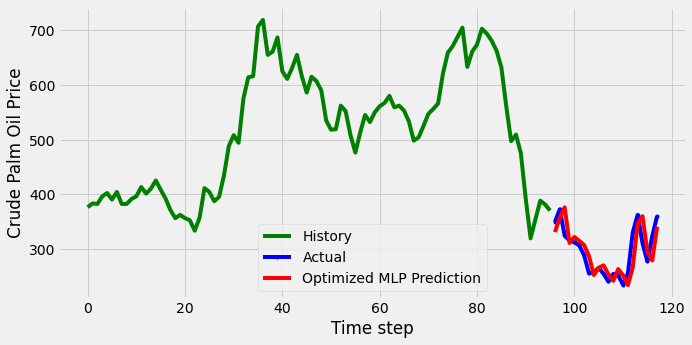

<Figure size 720x360 with 0 Axes>

In [82]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_MLP_Pred, color='red', label="Optimized MLP Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();
plt.savefig('MLPOpt.png')

###Evaluate MLP Model Accuracy

In [81]:
MAE_MLP = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the MLP Model is:', MAE_MLP)

MDA_MLP = mda(y_test_inv, y_pred_inv)
print('MDA value of the MLP Model is:', MDA_MLP)

MAPE_MLP = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the MLP Model is:', MAPE_MLP)

RMSE_MLP = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the MLP Model is:', RMSE_MLP)

MSE_MLP = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the MLP Model is:', MSE_MLP)

#EVS_MLP = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the MLP Model is:', EVS_MLP)

ValueError: ignored

###Tuning MLP with Keras Tuner

Define A Model-Building Class

In [ ]:
#class ANNhypermodel(HyperModel):
class MLPHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
      
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        #hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)
        #hp_units_4= hp.Int('units_4', min_value=16, max_value= 32, step=8)

        model.add(keras.layers.Dense(units=hp_units_1, input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2))
        #model.add(keras.layers.Dense(units=hp_units_3, activation='tanh'))
        #model.add(keras.layers.Dense(units=hp_units_4, activation='tanh'))
        model.add(keras.layers.Dense(1))
        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )
        
        # Tune the epoch for the optimizer

        #batch_size = hp.Int('batch_size',8,16,24,32,40,48,56,64,72,80,88,96, step=8)
        
        optimizers = hp.Choice('optimizer',values=['rmsprop','adam', 'AdamW', 'nadam','sgd','adadelta','adagrad'])

        hp_dense_activation = hp.Choice('activation',values=['relu', 'tanh', 'sigmoid', 'linear', 'Softmax', 'ELU', 'linear'])

        # Tune the batch size for the optimizer 
        hp_batch_size = hp.Int('batch_size', min_value = 8, max_value = 96, step = 8, default=8)
        
        # Tune the epoch for the optimizer
        hp_epoch = hp.Int('epoch', min_value = 5, max_value = 100, step = 5, default=5)

        # Tune the epoch for the momentum
        hp_momentum = hp.Float('momentum', min_value = 0.8, max_value = 0.99, step = 0.01, default=0.9)

        # Tune the epoch for the decay
        hp_decay = hp.Float('decay', min_value = 1e-9, max_value = 1e-3, step= 0.0001, default=1e-7)

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)
       # -------------------------------------------------------
        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

#hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
hypermodel = MLPHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [ ]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [ ]:
tuner_rs.search(X_train, y_train, epochs=16, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [ ]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 1s 1s/step - loss: 0.0511 - mae: 0.1861 - mse: 0.0511


####Random Search MSE = 0.0511

In [ ]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 64,
 'dropout': 0.1,
 'optimizer': 'adagrad',
 'activation': 'ELU',
 'batch_size': 24,
 'epoch': 75,
 'momentum': 0.9700000000000001,
 'decay': 0.000500001,
 'learning_rate': 0.00014948684422968163}

###Build Bayesian Optimization

In [ ]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [ ]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 302ms/step - loss: 0.1467 - mae: 0.3637 - mse: 0.1467


###Bayesian Optimization Search MSE = 0.1467

###Evaluate Bayesian Optimization

In [ ]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units_1': 128,
 'units_2': 128,
 'dropout': 0.25,
 'optimizer': 'adadelta',
 'activation': 'sigmoid',
 'batch_size': 24,
 'epoch': 40,
 'momentum': 0.8700000000000001,
 'decay': 0.00010000100000000001,
 'learning_rate': 0.001453129317743269}

In [ ]:
best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 305ms/step - loss: 0.1467 - mae: 0.3637 - mse: 0.1467


###Build HYPERBAND optimization

In [ ]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [ ]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [ ]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


1447.0631687641144  secs


###Hyperband MSE = 0.01193

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 


drop out is {best_hps.get('dropout')}
batch_size is {best_hps.get('batch_size')}
epoch is {best_hps.get('epoch')}
optimizer is {best_hps.get('optimizer')}
activation is {best_hps.get('activation')}

momentum is {best_hps.get('momentum')}
decay is {best_hps.get('decay')}

#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 160,
second layer is 96 


drop out is 0.35000000000000003
batch_size is 16
epoch is 95
optimizer is nadam
activation is linear

momentum is 0.93
decay is 0.000700001

#learning rate is 0.005469451505533658                                        

and the optimal learning rate for the optimizer
is 0.005469451505533658.

[]
1/1 [==============================] - 0s 478ms/step - loss: 0.0119 - mae: 0.0957 - mse: 0.0119
loss:0.011934570036828518 mae: 0.09570423513650894 mse: 0.011934570968151093


In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(best_hps.values)

{'units_1': 160, 'units_2': 96, 'dropout': 0.35000000000000003, 'optimizer': 'nadam', 'activation': 'linear', 'batch_size': 16, 'epoch': 95, 'momentum': 0.93, 'decay': 0.000700001, 'learning_rate': 0.005469451505533658, 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0176'}


###Apply the trained parameters to the MLP

In [ ]:
TUMLP_model = tf.keras.Sequential()
TUMLP_model.add(tf.keras.layers.MLP(160, activation='linear', input_shape=(X_test.shape[1], X_test.shape[2])))
TUMLP_model.add(tf.keras.layers.Dense(96, activation='linear'))
#TUMLP_model.add(layers.Dropout(0.35))

TUMLP_model.add(tf.keras.layers.Dense(48, activation='linear'))
#TUMLP_model.add(layers.Dropout(0.35))
#TUMLP_model.add(tf.keras.layers.Dense(16, 'tanh'))
#TUMLP_model.add(layers.Dropout(0.35))

#Output layer of model
TUMLP_model.add(tf.keras.layers.Dense(1))

In [ ]:
TUMLP_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Nadam(learning_rate=0.0054), metrics= ['mae', 'mse'])
#TUMLP_model.compile(optimizer='rmsprop',loss='mse',metrics=['mse']),
history = TUMLP_model.fit(X_train, y_train, epochs=95, batch_size=16,validation_split=0.2,shuffle=False) # 80/160

Epoch 1/95
5/5 [==============================] - 3s 77ms/step - loss: 0.5411 - mae: 0.6608 - mse: 0.5411 - val_loss: 0.0611 - val_mae: 0.2156 - val_mse: 0.0611
Epoch 2/95
5/5 [==============================] - 0s 21ms/step - loss: 0.0387 - mae: 0.1463 - mse: 0.0387 - val_loss: 0.0441 - val_mae: 0.1751 - val_mse: 0.0441
Epoch 3/95
5/5 [==============================] - 0s 24ms/step - loss: 0.0300 - mae: 0.1382 - mse: 0.0300 - val_loss: 0.0181 - val_mae: 0.1150 - val_mse: 0.0181
Epoch 4/95
5/5 [==============================] - 0s 18ms/step - loss: 0.0174 - mae: 0.1045 - mse: 0.0174 - val_loss: 0.0158 - val_mae: 0.0962 - val_mse: 0.0158
Epoch 5/95
5/5 [==============================] - 0s 21ms/step - loss: 0.0164 - mae: 0.1046 - mse: 0.0164 - val_loss: 0.0205 - val_mae: 0.1075 - val_mse: 0.0205
Epoch 6/95
5/5 [==============================] - 0s 22ms/step - loss: 0.0149 - mae: 0.1005 - mse: 0.0149 - val_loss: 0.0144 - val_mae: 0.0912 - val_mse: 0.0144
Epoch 7/95
5/5 [==================

Plot Model Loss

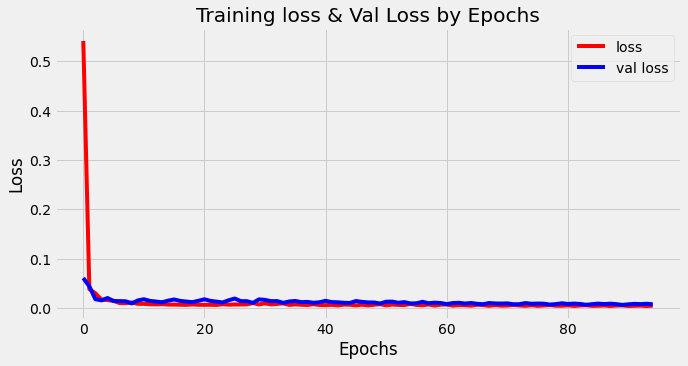

<Figure size 720x360 with 0 Axes>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs=range(len(loss)) 


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r',label='loss')
plt.plot(epochs,val_loss,'blue',label='val loss')
plt.title('Training loss & Val Loss by Epochs')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.figure()
plt.savefig('OptMLPTLV.png')

In [ ]:
y_predTU = TUMLP_model.predict(X_test)
y_predTU

1/1 [==============================] - 0s 236ms/step


array([[ 4.6107493e-02],
       [ 5.7388116e-02],
       [ 9.6546784e-02],
       [ 5.4676086e-05],
       [-1.1077775e-02],
       [-2.2343714e-02],
       [-4.0800724e-02],
       [-9.4636649e-02],
       [-1.7590389e-01],
       [-1.8414673e-01],
       [-1.5936276e-01],
       [-1.7143460e-01],
       [-1.9409403e-01],
       [-1.5373334e-01],
       [-1.6159666e-01],
       [-2.1800807e-01],
       [-1.9117294e-01],
       [ 1.5981626e-03],
       [ 8.7964788e-02],
       [-2.8456923e-02],
       [-9.9525958e-02],
       [ 2.5059525e-03]], dtype=float32)

In [ ]:
y_predTU.reshape(1,-1)

array([[ 4.6107493e-02,  5.7388116e-02,  9.6546784e-02,  5.4676086e-05,
        -1.1077775e-02, -2.2343714e-02, -4.0800724e-02, -9.4636649e-02,
        -1.7590389e-01, -1.8414673e-01, -1.5936276e-01, -1.7143460e-01,
        -1.9409403e-01, -1.5373334e-01, -1.6159666e-01, -2.1800807e-01,
        -1.9117294e-01,  1.5981626e-03,  8.7964788e-02, -2.8456923e-02,
        -9.9525958e-02,  2.5059525e-03]], dtype=float32)

###Invert Transformed Tuned Data

In [ ]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_predTU.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[337.443   341.95526 357.6187  319.02188 314.5689  310.0625  302.67972
  281.14532 248.63844 245.34131 255.25488 250.42618 241.36238 257.50665
  254.36134 231.79677 242.53082 319.63925 354.1859  307.61725 279.1896
  320.00238]]


In [ ]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [ ]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [ ]:
TU_MLP_Pred = y_pred_inv.flatten()   #y_pred_inv = TU_MLP_Pred
TU_MLP_Pred

array([337.443  , 341.95526, 357.6187 , 319.02188, 314.5689 , 310.0625 ,
       302.67972, 281.14532, 248.63844, 245.34131, 255.25488, 250.42618,
       241.36238, 257.50665, 254.36134, 231.79677, 242.53082, 319.63925,
       354.1859 , 307.61725, 279.1896 , 320.00238], dtype=float32)

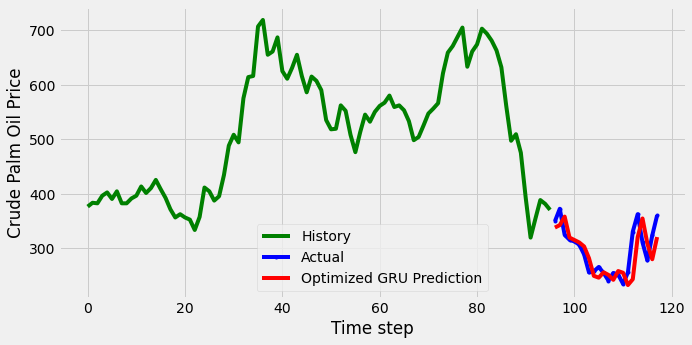

<Figure size 720x360 with 0 Axes>

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), TU_MLP_Pred, color='red', label="Optimized MLP Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time step')
plt.legend()
plt.show();
plt.savefig('MLPOpt.png')

### Optimized MLP Model Metric

In [ ]:
TUMAE_MLP = mean_absolute_error(y_test_inv, TU_MLP_Pred)
print('MAE value of the MLP Model is:', TUMAE_MLP)

TUMDA_MLP = mda(y_test_inv, TU_MLP_Pred)
print('MDA value of the tuned MLP Model is:', TUMDA_MLP)

TUMAPE_MLP = mean_absolute_percentage_error(y_test_inv, TU_MLP_Pred)
print('MAPE value of the tuned MLP Model is:', TUMAPE_MLP)

TURMSE_MLP = mean_squared_error(y_test_inv,TU_MLP_Pred, squared=False)
print('RMSE value of the tuned MLP Model is:', TURMSE_MLP)

TUMSE_MLP = mean_squared_error(y_test_inv,TU_MLP_Pred)
print('MSE value of the tuned MLP Model is:', TUMSE_MLP)

MAE value of the GRU Model is: 23.525002219460227
MDA value of the tuned GRU Model is: 0.5714285714285714
MAPE value of the tuned GRU Model is: 7.709507454513364
RMSE value of the tuned GRU Model is: 30.65998310153814
MSE value of the tuned GRU Model is: 940.0345637866042


###Optimized MLP model prediction visualization

Comparing tuned MLP Actual VS Predicted (Zoomed-IN)

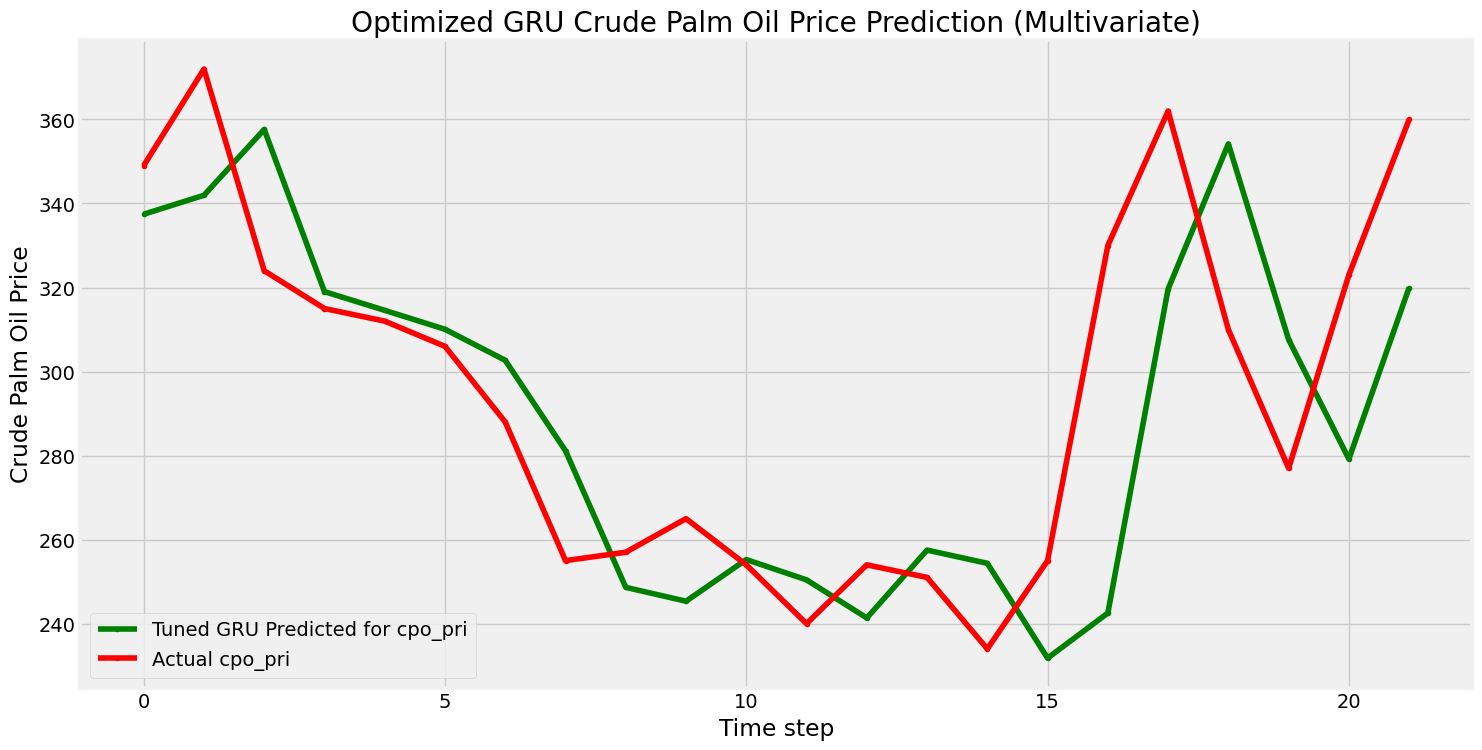

<Figure size 720x360 with 0 Axes>

In [ ]:
#Plot the graph between actual vs predicted values
#plt.figure(figsize=(15,7))  #(10,6))
plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(TU_MLP_Pred, color= 'green',marker='.',label = 'Tuned MLP Predicted - cpo_pri')
plt.plot(y_test_inv, color = 'red',marker='.',label = 'Actual cpo_pri ')
plt.title("Optimized MLP Crude Palm Oil Price Prediction (Multivariate)")
plt.xlabel("Time step")
plt.ylabel("Crude Palm Oil Price")
plt.legend()
plt.show()
plt.savefig('graph_TUMLP.png')

###Comparing the optimized MLP, MLP, Bayesian and Random search models

* Baseline MLP MSE = 0.0153
* Random search MSE = 0.0511
* Bayesian search MSE = 0.1467
* Hyperband search MSE = 0.0119
* Baseline MLP RSME = 45.29
* Optimized MLP RSME = 30.65

The tuned MLP is superior to the basseline based on the RSME result